In [3]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
%matplotlib inline


Read in the Data 

In [4]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()




,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
306,13.20,15.82,84.07,537.3,0.08511,0.05251,0.001461,0.003261,0.1632,0.05894,...,14.41,20.45,92.00,636.9,0.1128,0.13460,0.011200,0.025000,0.2651,0.08385
199,14.45,20.22,94.49,642.7,0.09872,0.12060,0.118000,0.059800,0.1950,0.06466,...,18.33,30.12,117.90,1044.0,0.1552,0.40560,0.496700,0.183800,0.4753,0.10130
20,13.08,15.71,85.63,520.0,0.10750,0.12700,0.045680,0.031100,0.1967,0.06811,...,14.50,20.49,96.09,630.5,0.1312,0.27760,0.189000,0.072830,0.3184,0.08183
285,12.58,18.40,79.83,489.0,0.08393,0.04216,0.001860,0.002924,0.1697,0.05855,...,13.50,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431
225,14.34,13.47,92.51,641.2,0.09906,0.07624,0.057240,0.046030,0.2075,0.05448,...,16.77,16.90,110.40,873.2,0.1297,0.15250,0.163200,0.108700,0.3062,0.06072


In [5]:
# check for null values 
data.isnull().sum().sum()

0

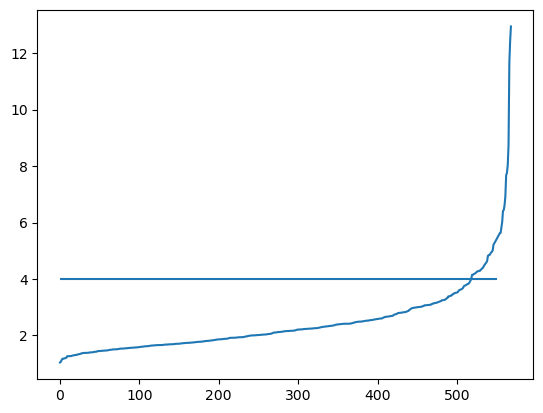

In [6]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=4, xmin=0, xmax=550)
# best eps around 3.75
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 31


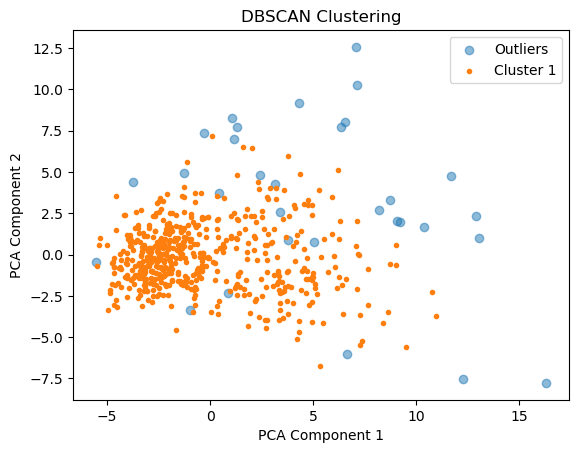

In [27]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

for label in np.unique(labels):
    if label == -1:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='o', label='Outliers', alpha=0.5)
    else:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='.', label=f'Cluster {label + 1}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


In [8]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [9]:
outputs = []


In [10]:


#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,6,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Chosen max_depth: 31
Chosen min_samples_leaf: 1
Chosen max_depth: 37
Chosen min_samples_leaf: 1
Chosen max_depth: 37
Chosen min_samples_leaf: 1
Chosen max_depth: 39
Chosen min_samples_leaf: 3
Chosen max_depth: 33
Chosen min_samples_leaf: 1


In [11]:
#ADA Boosting
param_grid = {
    'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Chosen n_estimators: 110
Chosen n_estimators: 140
Chosen n_estimators: 100
Chosen n_estimators: 120
Chosen n_estimators: 120


In [12]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': list(range(10, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


AttributeError: module 'sklearn' has no attribute 'pipeline'

In [ ]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': list(range(7,13)),
    'knn__n_neighbors': list(range(3,7))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



In [ ]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,),(70,),(80,)],
    "nn__activation": ["logistic","tanh","relu"],
    "nn__max_iter" : [200,250,300,350]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



In [ ]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

In [ ]:
## save model here?